In [2]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from termcolor import colored as cl
from math import floor

In [ ]:
start_date = datetime(2010,1,1)
end_date = datetime(2023,5,1)
data = yf.download("^IXIC ^NSEI", start = start_date, end = end_date, auto_adjust=True)[['Close']]
data.head()

In [4]:
# Correlation calulcation
common_days = data['Close']['^IXIC'].index.intersection(data['Close'].index)
nas = data['Close']['^IXIC'].loc[common_days]
nse = data['Close']['^NSEI'].loc[common_days]
corr = nas.corr(nse, method = 'pearson')
print('Correlation between two indices:', corr)
print('Strong correlation (coefficient near to 1) and positive')

Correlation between two indices: 0.9513138758576785
Strong correlation (coefficient near to 1) and positive


Text(0, 0.5, 'Close')

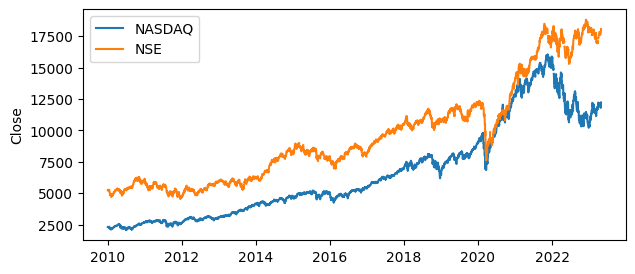

In [5]:
# Calculation of lead-lag relationship
plt.figure(figsize=(7,3))
plt.plot(nas, label='NASDAQ')
plt.plot(nse, label='NSE')
plt.legend(loc = "upper left", prop = {'size' : 10})
plt.ylabel('Close')

In [6]:
# Estimating lead-lag relationship
# Augmented Dicky Fuller test to check for stationarity of time series
from statsmodels.tsa.stattools import adfuller
def adftest(series):
    dftest = adfuller(series, autolag='AIC')
    result = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No of Observations'])
    for key,value in dftest[4].items(): result['Critical Value (%s)'%key] = value
    return result

In [7]:
# Checking for null values in the dataset
a = nas.isnull().sum()
b = nse.isnull().sum()
print(a, b)

# filling the nan values with avg of upper and lower value
nas = (nas.ffill()+nas.bfill())/2    # considered also the case when it has consecutive nans
nse = (nse.ffill()+nse.bfill())/2
nas = nas.bfill().ffill()  # if last or the first value is nan
nse = nse.bfill().ffill()

86 171


In [8]:
adftest(nas)

Test Statistic            -0.387187
P-value                    0.912216
Lags Used                 28.000000
No of Observations      3410.000000
Critical Value (1%)       -3.432269
Critical Value (5%)       -2.862388
Critical Value (10%)      -2.567221
dtype: float64

In [9]:
adftest(nse)

Test Statistic             0.251349
P-value                    0.974999
Lags Used                 10.000000
No of Observations      3428.000000
Critical Value (1%)       -3.432259
Critical Value (5%)       -2.862384
Critical Value (10%)      -2.567219
dtype: float64

In [10]:
# Series are non stationary
# Detrending the series
from numpy import polyfit

def fit(X, y, degree=5):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_trend(s, degree=5):
    X = list(range(len(s)))  # (s.index.year - s.index.year.min()).values
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

In [11]:
tnas = get_trend(nas)
tnse= get_trend(nse)
nasdet = nas - tnas
nsedet = nse - tnse

Text(0, 0.5, 'Close')

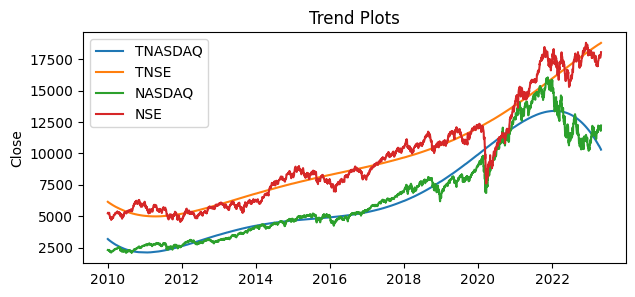

In [12]:
plt.figure(figsize=(7,3))
plt.title('Trend Plots')
plt.plot(tnas, label='TNASDAQ')
plt.plot(tnse, label='TNSE')
plt.plot(nas, label='NASDAQ')
plt.plot(nse, label='NSE')
plt.legend(loc = "upper left", prop = {'size' : 10})
plt.ylabel('Close')

Text(0, 0.5, 'Close')

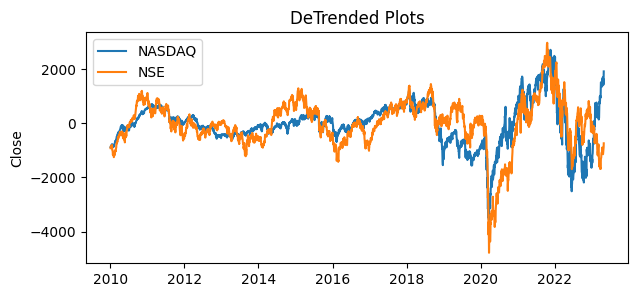

In [13]:
plt.figure(figsize=(7,3))
plt.title('DeTrended Plots')
plt.plot(nasdet, label='NASDAQ')
plt.plot(nsedet, label='NSE')
plt.legend(loc = "upper left", prop = {'size' : 10})
plt.ylabel('Close')

In [14]:
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

ccf = ccf_values(nasdet, nsedet)
lags = signal.correlation_lags(400, 400)
ccf = ccf[int((ccf.shape[0]-1)/2) - 399 :]
ccf = ccf[:799]
max_corr = max(ccf.min(), ccf.max(), key=abs)
max_index = np.where(ccf == max_corr)
print('max correlation between two indices:', max_corr, 'with lag =', lags[max_index[0]][0])

max correlation between two indices: 0.6547808307666327 with lag = -1


In [15]:
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(7, 3))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation plot', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold',fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend(loc = "upper right", prop = {'size' : 10})

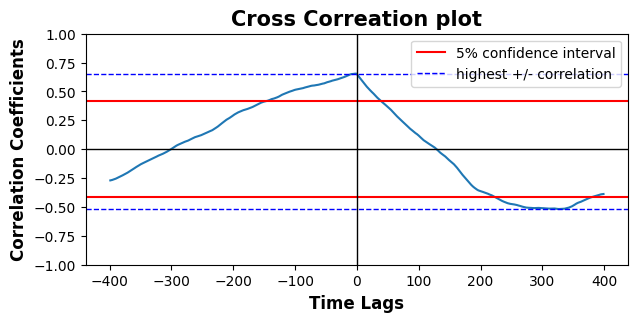

In [122]:
ccf_plot(lags, ccf)

In [ ]:
# Indicator Coding
start_date = datetime(2010,1,1)
end_date = datetime(2023,5,1)
df = yf.download("^NSEI", start = start_date, end = end_date, auto_adjust=True)
df.head()

In [63]:
# Keltner Channel
def expmovavg(data):
    return data['Close'].ewm(span=20, adjust=False).mean()
    
def get_ATR(data):
    data['H-L'] = data['High'] - data['Low']
    data['H-C'] = abs(data['High'] - data['Close'].shift(1))
    data['C-L'] = abs(data['Close'].shift(1) - data['Low'])
    data['TrueRange'] = data[['H-L', 'H-C', 'C-L']].max(axis=1)
    data['ATR'] = data['TrueRange'].rolling(window=10).mean()
    return data['ATR']

EMA = expmovavg(df)
ATR = get_ATR(df)
upper_band = EMA + (2*ATR)
lower_band = EMA - (2*ATR)


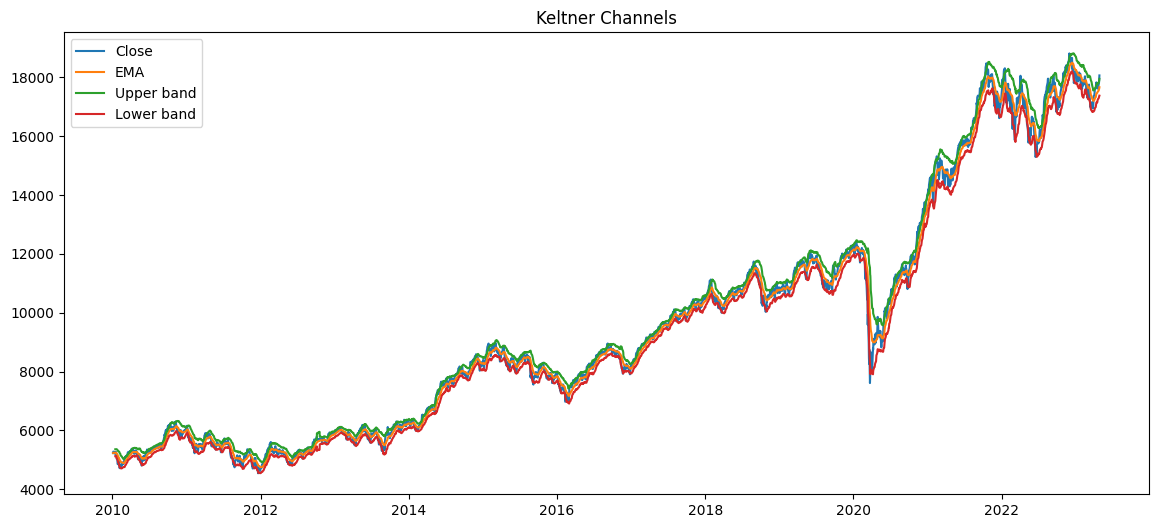

In [64]:
plt.figure(figsize=(14,6))
plt.title('Keltner Channels')
plt.plot(df['Close'], label='Close')
plt.plot(EMA, label='EMA')
plt.plot(upper_band, label='Upper band')
plt.plot(lower_band, label='Lower band')
plt.legend(loc = "upper left", prop = {'size' : 10})

In [65]:
# Parameter optimization and signal generation  
# Keltner channel strategy (breakout strategy)
def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0

    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

In [66]:
buy_price, sell_price, kc_signal = implement_kc_strategy(df['Close'], upper_band, lower_band)

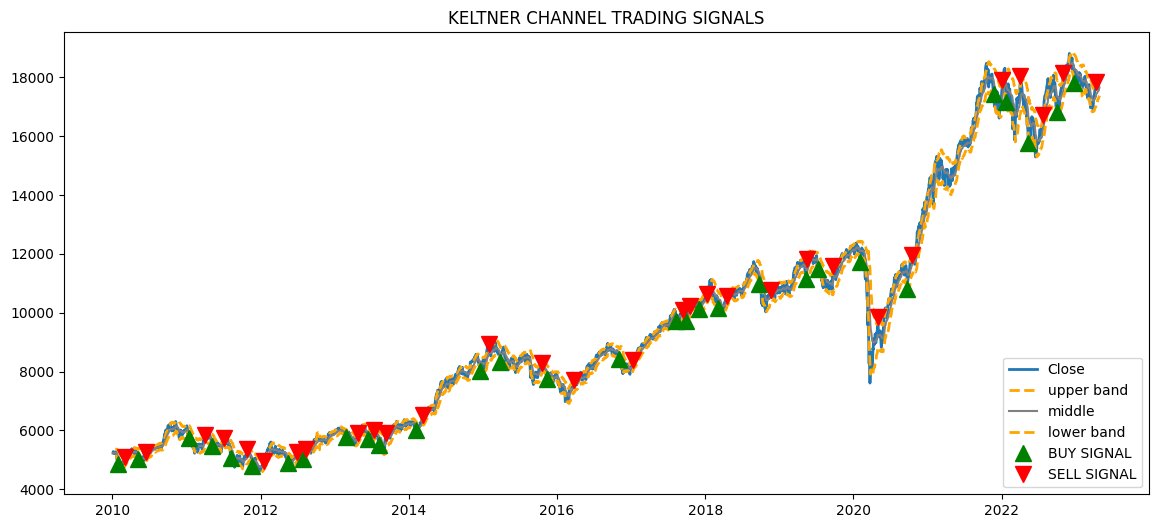

In [68]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], linewidth = 2, label = 'Close')
plt.plot(upper_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'upper band')
plt.plot(EMA, linewidth = 1.5, color = 'grey', label = 'middle')
plt.plot(lower_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'lower band')
plt.plot(df.index[:3267], buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(df.index[:3267], sell_price, marker = 'v', color= 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('KELTNER CHANNEL TRADING SIGNALS')
plt.show()

In [70]:
position = []
for i in range(len(kc_signal)):
    if kc_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(0,len(df['Close'])-1):
    if kc_signal[i] == 1:
        position[i] = 1
    elif kc_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
kc_signal = pd.DataFrame(kc_signal).rename(columns = {0:'kc_signal'}).set_index(df[:3267].index)
position = pd.DataFrame(position).rename(columns = {0:'kc_position'}).set_index(df[:3267].index)
frames = [df['Close'], upper_band, lower_band, kc_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy.head()
# backtesting
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
kc_strategy_ret = []
for i in range(len(df_ret)):
    returns = df_ret['returns'][i]*strategy['kc_position'][i]
    kc_strategy_ret.append(returns)

kc_strategy_ret_df = pd.DataFrame(kc_strategy_ret).rename(columns = {0:'kc_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['Close'][0])
kc_investment_ret = []

for i in range(len(kc_strategy_ret_df['kc_returns'])):
    returns = number_of_stocks*kc_strategy_ret_df['kc_returns'][i]
    kc_investment_ret.append(returns)

In [71]:
# ratios
buy_price_list = [x for x in buy_price if x == x]
sell_price_list = [x for x in sell_price if x == x]
buy_price_list = np.array(buy_price_list)
sell_price_list = np.array(sell_price_list)
returns = ((sell_price_list - buy_price_list)/buy_price_list)*100

In [72]:
# sharpe ratio
SR = returns.mean()/returns.std()
# MDD
MDD = returns.min()
# cumulative return
cmm_return = returns.sum()

print(SR, MDD, cmm_return)

0.7853040917015882 -15.784213551046012 114.99319644917716


In [73]:
# Bollinger Bands
df_mean = df['Close'].rolling(window=20).mean()
df_std = df['Close'].rolling(window=20).std()
upper_band = df_mean + (df_std * 2)
lower_band = df_mean - (df_std * 2)

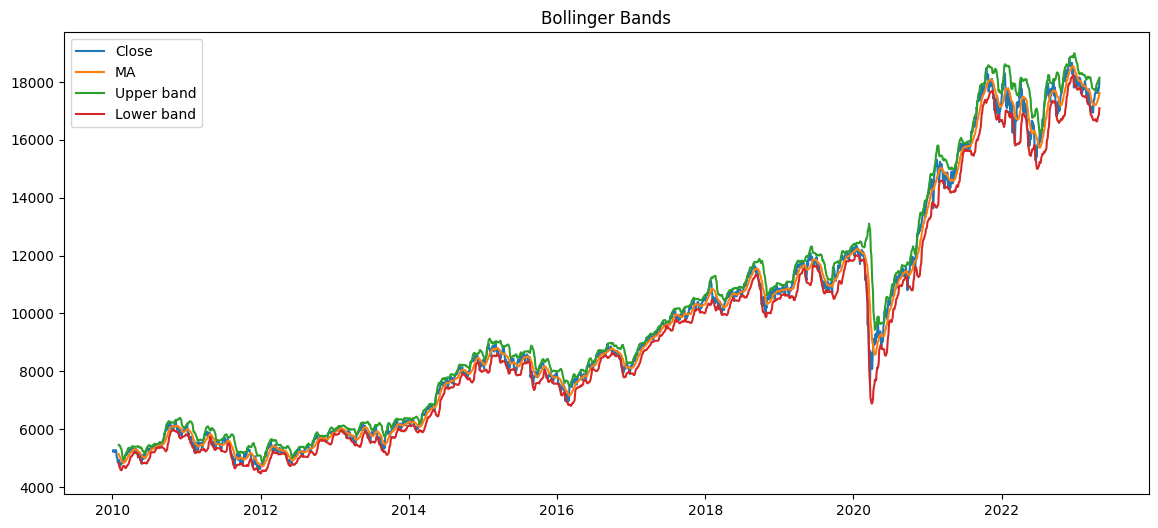

In [74]:
plt.figure(figsize=(14,6))
plt.title('Bollinger Bands')
plt.plot(df['Close'], label='Close')
plt.plot(df_mean, label='MA')
plt.plot(upper_band, label='Upper band')
plt.plot(lower_band, label='Lower band')
plt.legend()

In [75]:
# Parameter optimization and signal generation  
# Bollinger bands strategy
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [76]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df['Close'], lower_band, upper_band)

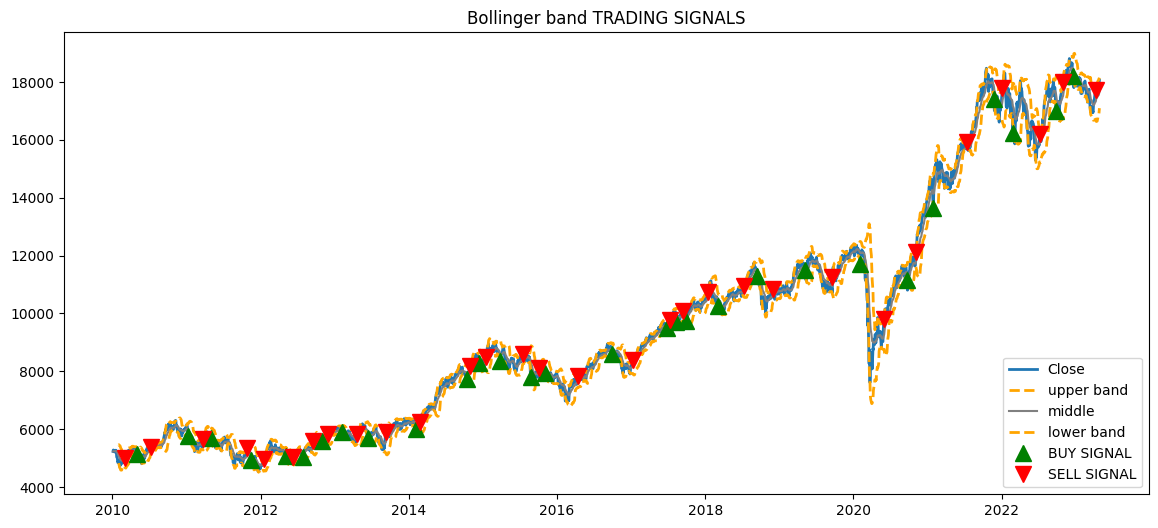

In [77]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], linewidth = 2, label = 'Close')
plt.plot(upper_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'upper band')
plt.plot(EMA, linewidth = 1.5, color = 'grey', label = 'middle')
plt.plot(lower_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'lower band')
plt.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(df.index, sell_price, marker = 'v', color= 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('Bollinger band TRADING SIGNALS')
plt.show()

In [78]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['Close'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df.index)

frames = [df['Close'], upper_band, lower_band, bb_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()
# backtesting
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []
for i in range(len(df_ret)):
    returns = df_ret['returns'][i]*strategy['bb_position'][i]
    bb_strategy_ret.append(returns)

bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['Close'][0])
bb_investment_ret = []

for i in range(len(bb_strategy_ret_df['bb_returns'])):
    returns = number_of_stocks*bb_strategy_ret_df['bb_returns'][i]
    bb_investment_ret.append(returns)

In [80]:
buy_price_list = [x for x in buy_price if x == x]
sell_price_list = [x for x in sell_price if x == x]
buy_price_list = np.array(buy_price_list)
sell_price_list = np.array(sell_price_list)
returns = ((sell_price_list[1:] - buy_price_list)/buy_price_list)*100

In [81]:
# ratios
# sharpe ratio
SR = returns.mean()/returns.std()
# MDD
MDD = returns.min()
# cumulative return
cmm_return = returns.sum()

print(SR, MDD, cmm_return)

0.3589280553419877 -16.072480438138978 61.52566010185612


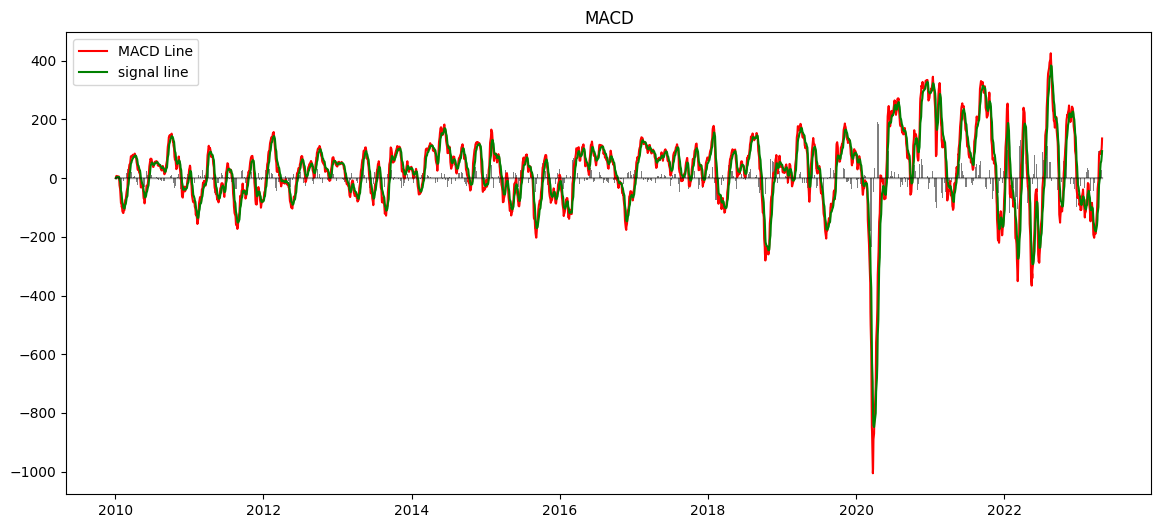

In [82]:
# MACD
# 26 days EMA of closing price
l = df['Close'].ewm(span=26, adjust=False).mean()
# 12 days EMA of closing price
u = df['Close'].ewm(span=12, adjust=False).mean()

macd = u - l
signal_line = macd.ewm(span=9, adjust=False).mean()
hist = macd - signal_line
Date = df.index
plt.figure(figsize=(14,6))
plt.title('MACD')
plt.plot(Date, macd, label='MACD Line', color='red')
plt.plot(Date, signal_line, label='signal line',color='green')
plt.plot(Date, np.zeros(len(df)),color='black', alpha=0.4)
plt.bar(Date, hist, color='black', alpha=0.5)
plt.legend()

In [83]:
# Parameter optimization and signal generation  
# MACD strategy
def implement_macd_strategy(prices, macd, signal_line):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(prices)):
        if macd[i] > signal_line[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif macd[i] < signal_line[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

In [84]:
buy_price, sell_price, macd_signal = implement_macd_strategy(df['Close'], macd, signal_line)

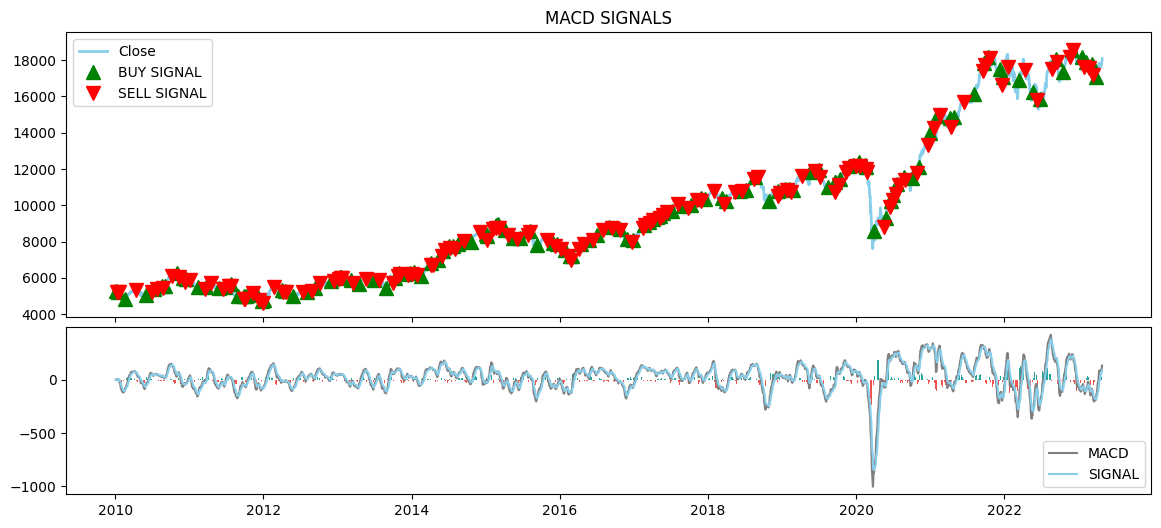

In [85]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)
ax1.plot(df['Close'], color = 'skyblue', linewidth = 2, label = 'Close')
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('MACD SIGNALS')
ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(signal_line, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
for i in range(len(macd)):
    if str(hist[i])[0] == '-':
        ax2.bar(macd.index[i], hist[i], color = '#ef5350')
    else:
        ax2.bar(macd.index[i], hist[i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()


In [86]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(df.index)

frames = [df['Close'], macd, signal_line, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()
# backtesting
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(df_ret)):
    returns = df_ret['returns'][i]*strategy['macd_position'][i]
    macd_strategy_ret.append(returns)

macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

In [87]:
buy_price_list = [x for x in buy_price if x == x]
sell_price_list = [x for x in sell_price if x == x]
buy_price_list = np.array(buy_price_list)
sell_price_list = np.array(sell_price_list)
returns = ((sell_price_list - buy_price_list[:-1])/buy_price_list[:-1])*100

In [88]:
# ratios
# sharpe ratio
SR = returns.mean()/returns.std()
# MDD
MDD = returns.min()
# cumulative return
cmm_return = returns.sum()

print(SR, MDD, cmm_return)

0.18754087997629595 -5.654283738290179 86.84878537099502
